## Pseudo-random number generators (PRNG)
In this notebook, different Pseudo-Random Number Generators (PRNG) are explored. The attention is focused mainly on PRNG for the uniform and normal distributions. 

In [1]:
R.version

               _                           
platform       x86_64-apple-darwin17.0     
arch           x86_64                      
os             darwin17.0                  
system         x86_64, darwin17.0          
status                                     
major          4                           
minor          0.0                         
year           2020                        
month          04                          
day            24                          
svn rev        78286                       
language       R                           
version.string R version 4.0.0 (2020-04-24)
nickname       Arbor Day                   

In [2]:
require(uniftest)

Loading required package: uniftest

Warning message:
“package ‘uniftest’ was built under R version 4.0.2”
Loading required package: orthopolynom

Warning message:
“package ‘orthopolynom’ was built under R version 4.0.2”
Loading required package: polynom

Warning message:
“package ‘polynom’ was built under R version 4.0.2”


#### Uniform PRNG - Linear Congruential Generator

First, uniform PRNG are studied. The most elementary is the Linear Congruential Generator (LGC), based on the
recurrence relation $X_{n+1} = (a X_n + c) \mod m$ 

In [3]:
lgc = function(n, a, c, m, seed) {
    numbers = numeric()
    x = seed
    while (length(numbers) < n) {
        x = (a * x + c) %% m
        numbers = c(numbers, x)
    }
    return(numbers/(m-1))
}

In [4]:
a = 11551
c = 27077
m = 2**32
unif_lgc <- lgc(10000, a, c, m, 101)

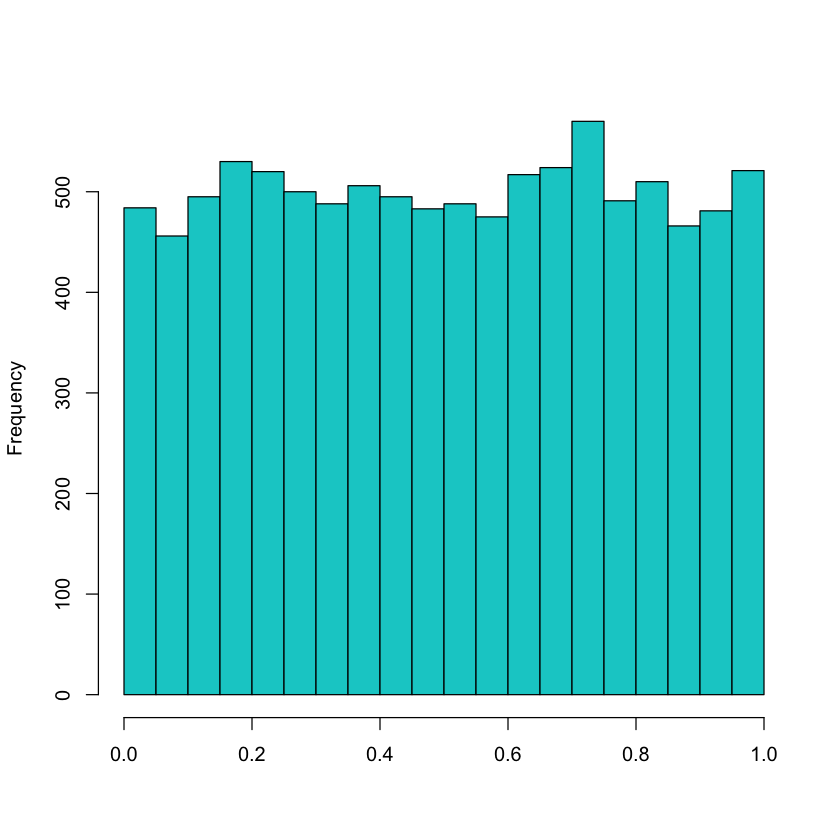

In [5]:
hist(unif_lgc, col = "cyan3", xlab='', main='')

In [10]:
png(filename="unif_lgc.png", height=2000, width=2000, res=400)
hist(unif_lgc, col = "cyan3", xlab='', main='')
dev.off()

pdf 
  2

In [11]:
frosini.unif.test(unif_lgc)


	Frosini test for uniformity

data:  unif_lgc
B = 0.32026, p-value = 0.3845


****************

The sequence LGC outputs has length at most $m$, but it can be smaller. Conditions for the output to be of length $m$ 
are: $a, m$ must be coprime, $a-1$ must be divisible by all prime factors of $m$, and $a-1$ is divisible by 4 if $m$ is divisible by 4. See https://chagall.med.cornell.edu/BioinfoCourse/PDFs/Lecture4/random_number_generator.pdf for a proof of this fact.

Example of $a$, $m$ coprime

In [12]:
a = 2**10 + 1
c = 2**16 + 1
m = 2**32

In [13]:
pvalues <- numeric()
for (i in 1:100){
    seed <- sample(100:1000, 1)
    pvalues <- c(pvalues, frosini.unif.test(lgc(1000,a,c,m, seed))$p)
}


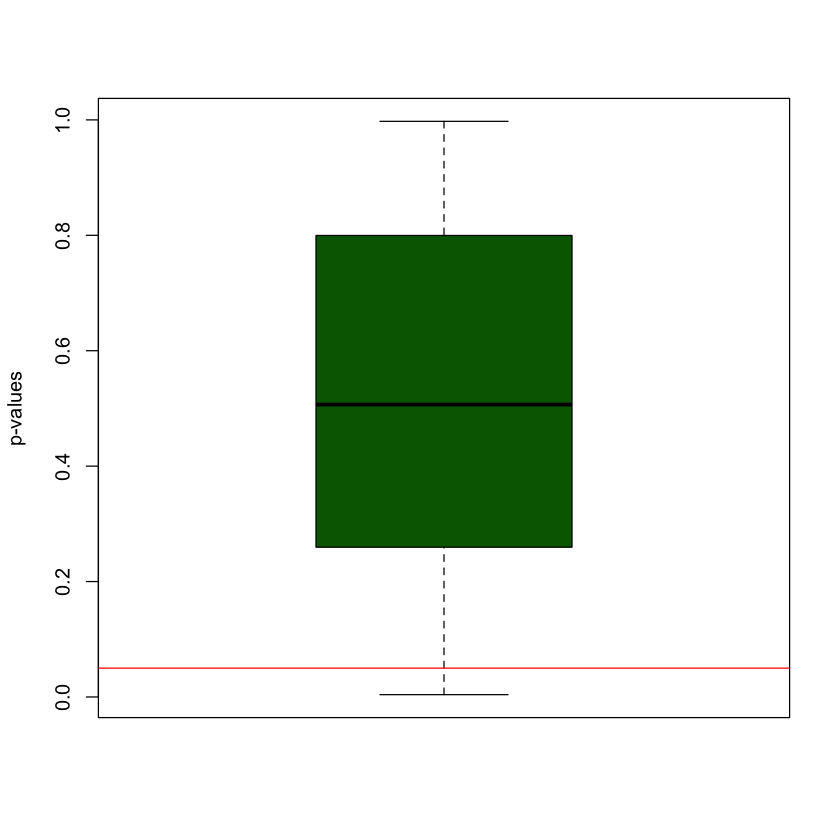

In [14]:
boxplot(pvalues, ylab='p-values', col="darkgreen")
abline(h=0.05, col ="Red")

In [16]:
png(filename="boxplot_pvalues_lgc.png", height=2000, width=2000, res=400)
boxplot(pvalues, ylab='p-values', col="darkgreen")
abline(h=0.05, col ="Red")
dev.off()

pdf 
  2

In [15]:
table(pvalues < 0.05)


FALSE  TRUE 
   93     7 

Example of $a, m$ **not** coprime

In [17]:
a = 2**10
c = 2**16 + 1
m = 2**32

In [18]:
pvalues2 <- numeric()
for (i in 1:100){
    seed <- sample(100:1000, 1)
    pvalues2 <- c(pvalues2, frosini.unif.test(lgc(1000,a,c,m, seed))$p)
}


In [93]:
sherman.unif.test(lgc(1000,a,c,m, seed))


	Sherman test for uniformity

data:  lgc(1000, a, c, m, seed)
W = 0.996, p-value < 2.2e-16


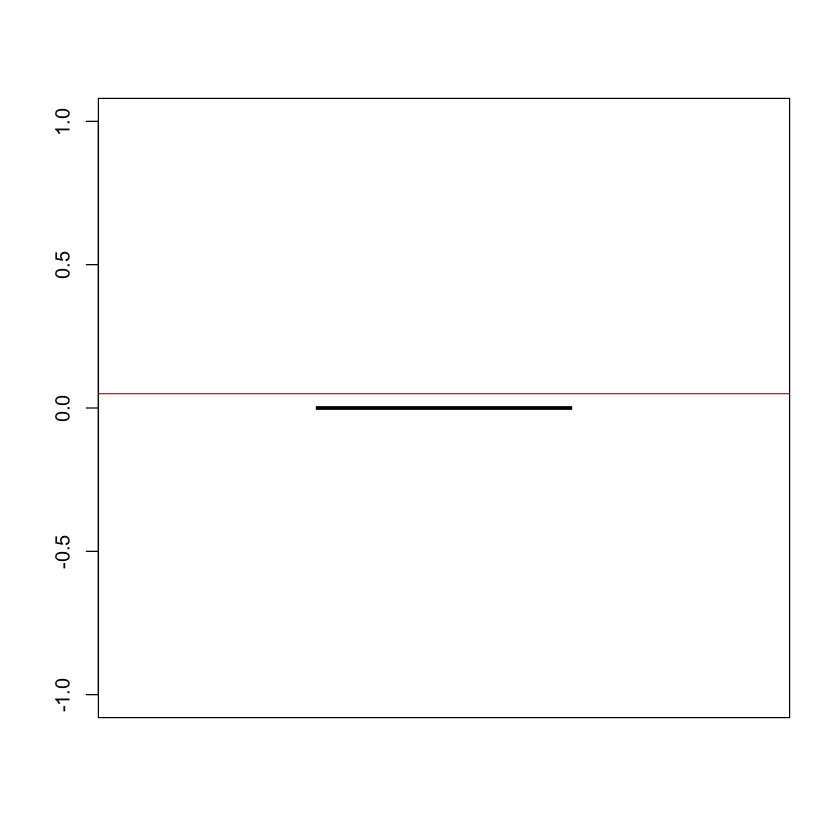

In [19]:
boxplot(pvalues2)
abline(h=0.05, col = "Red")

In [20]:
png(filename="boxplot_pvalues_bad_lgc.png", height=2000, width=2000, res=400)
boxplot(pvalues2)
abline(h=0.05, col = "Red")
dev.off()

pdf 
  2

In [21]:
table(pvalues2 < 0.05)


TRUE 
 100 

#### Additive Congruential Random Number Generator
Another method is the Additive Congruential Random Number Generator (ACORN) (http://acorn.wikramaratna.org/concept.html).
It starts with $k$ initial values $Y_{0}^{m}, m = 1, 2, \dots, k$ all being less than a modulus $M$. With this, the following are defined:

$Y_{n}^{0} = Y_{n-1}^{0}, n \geq 1$

$Y_{n}^{m} = (Y_{n}^{m-1} + Y_{n-1}^{m} ) \mod M, n \geq 1, m =  1, 2, \dots, k$

$X_{n}^{k}  = Y_{n}^{k} / M, n \geq 1$

The sequence $X_{n}^{k}$ is the sequence of ACORN pseudo-random numbers.

In [22]:
acorn <- function(howmany){
    k <- 20

    M <- 2**64

    semilla <- 0
    while(semilla %% 2 == 0){
        semilla <- sample(2**10 : 2**20, 1)
    }

    init <- c(semilla, sample(2**20 : 2** 40, k-1))

    A <- matrix(data = .5, nrow = howmany, ncol = k)

    A[c(1), seq(1,k,1)] <- init

    for (row in (2:howmany)){
        for (col in (1:k)){
            if (col == 1){
                A[c(row), c(col)] <- A[c(row-1), c(col)]
            }
            else{
                x <- A[c(row), c(col-1)] + A[c(row-1), c(col)]
                A[c(row), c(col)] <- x %% M
            }
        }
        }
    x <- A[seq(1,howmany,1), c(k)]

    x <- x/M
    
    return(x)
    }

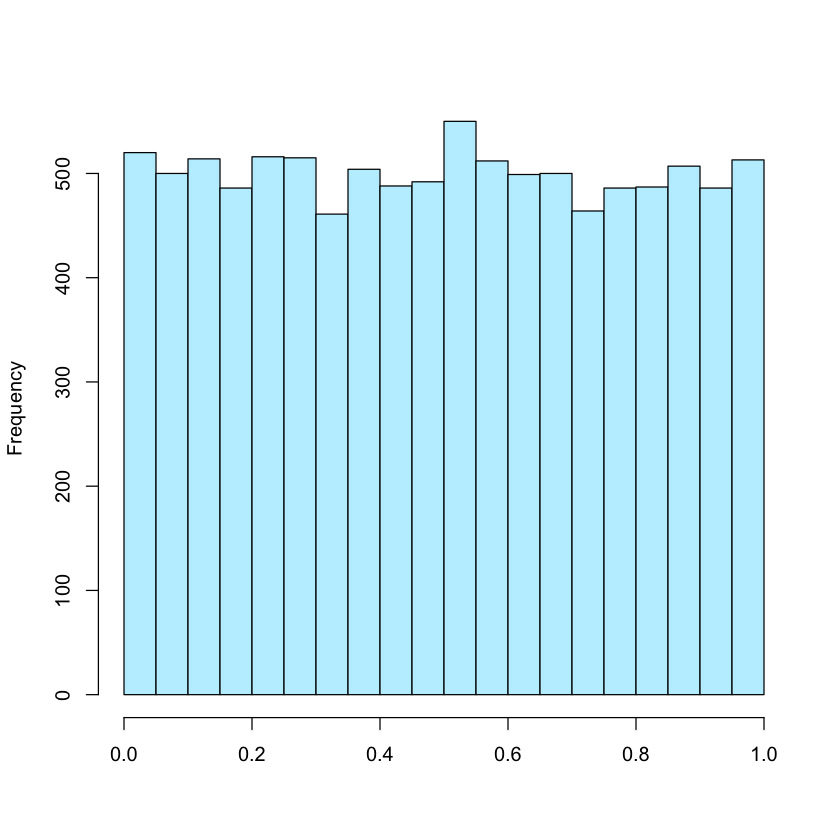

In [95]:
hist(acorn(10000), main="", xlab="", col = "lightblue1")

In [96]:
png(filename="unif_acorn_hist.png", height=2000, width=2000, res=400)
hist(acorn(10000), main="", xlab="", col = "lightblue1")
dev.off()

pdf 
  2

In [23]:
pvalues_acorn <- numeric()
for(i in 1:100){
    pvalues_acorn <- c(pvalues_acorn, frosini.unif.test(acorn(1000))$p)
}

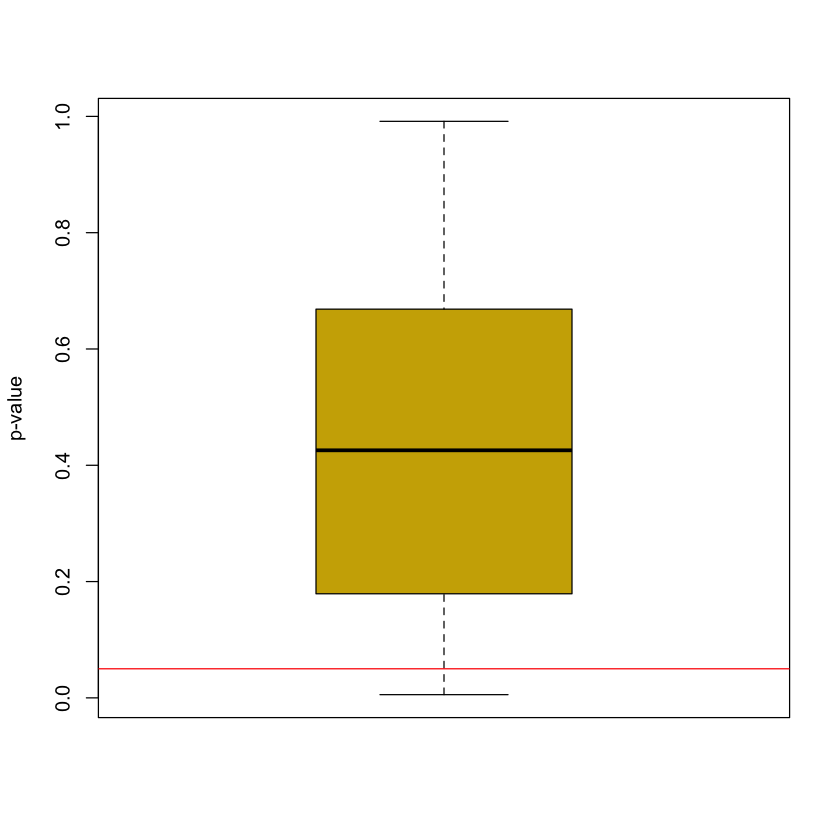

In [24]:
boxplot(pvalues_acorn, ylab='p-value', col = "gold3")
abline(h=0.05, col="Red")

In [25]:
png(filename="boxplot_pvalues_acorn.png", height=2000, width=2000, res=400)
boxplot(pvalues_acorn, ylab='p-value', col = "gold3")
abline(h=0.05, col="Red")
dev.off()

pdf 
  2

In [26]:
table(pvalues_acorn < 0.05)


FALSE  TRUE 
   95     5 

******************************
### Normal distributed PRNG. 
#### Box-muller
Box-muller transform method is presented. Function ```gaussian``` was coded by Prof. Elisa Schaeffer

In [27]:
#Gaussian (Elisa)
gaussian = function(mu, sigma) {
    u = runif(2);
    z0 = sqrt(-2 * log(u[1])) * cos(2 * pi * u[2]);
    z1 = sqrt(-2 * log(u[1])) * sin(2 * pi * u[2]);
    datos = c(z0, z1);
    return (sigma * datos + mu);
}

We compare the ```gaussian``` generator with R's ```rnorm```, and with two modifications of ```gaussian``` which keep only the first and the second number generated, respectively.

In [28]:
pvalues_firstz <- numeric()
for (i in 1:100){
    first_z <- numeric()
    for (i in 1:5000){
        first_z <- c(first_z, gaussian(0,1)[1])
    }
    pvalues_firstz <- c(pvalues_firstz, shapiro.test(first_z)$p)
    
}

In [29]:
pvalues_secondz <- numeric()
for (i in 1:100){
    second_z <- numeric()
    for (i in 1:5000){
        second_z <- c(second_z, gaussian(0,1)[2])
    }
    pvalues_secondz <- c(pvalues_secondz, shapiro.test(second_z)$p)
}   

In [30]:
pvalues_gauss <- numeric()
for (i in 1:100){
    gauss <- numeric()
    for (i in 1:2500){
        gauss <- c(gauss, gaussian(0,1))
    }
    pvalues_gauss <- c(pvalues_gauss, shapiro.test(gauss)$p)

}

In [31]:
pvalues_rnorm <- numeric()
for (i in 1:100){
    x <- rnorm(n = 5000, mean = 0, sd = 1)
    pvalues_rnorm <- c(pvalues_rnorm, shapiro.test(x)$p)
}

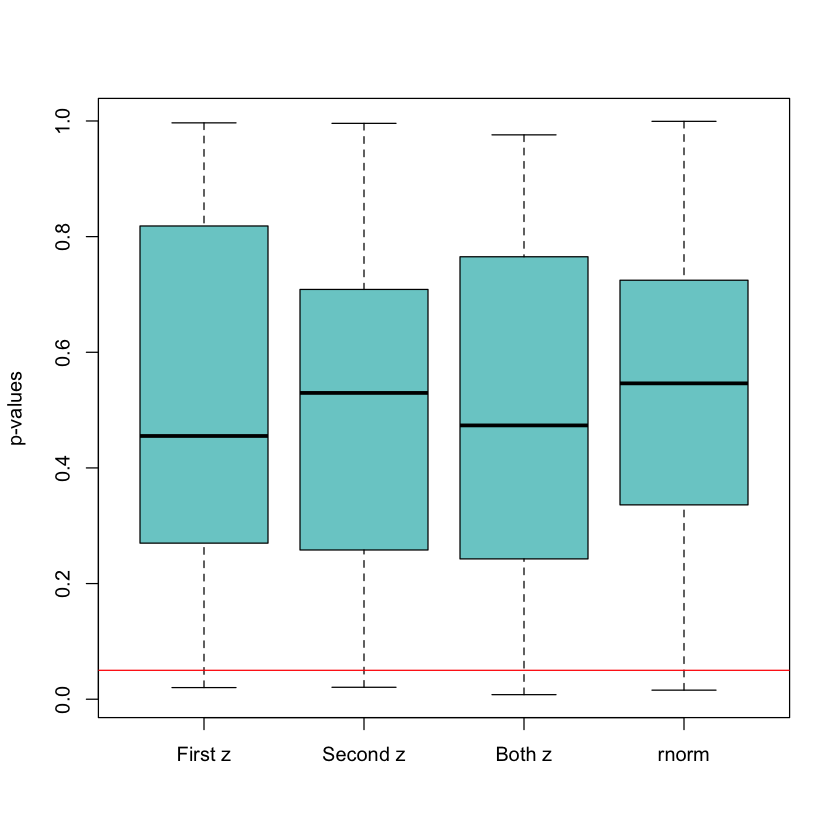

In [32]:
boxplot(pvalues_firstz, 
        pvalues_secondz,
        pvalues_gauss, 
        pvalues_rnorm,
       ylab='p-values',
       names = c("First z", "Second z", "Both z", "rnorm"),
       col = "darkslategray3")
abline(h=0.05, col ="Red")

In [33]:
png(filename="various_normal_pvalues.png", height=2000, width=2000, res=400)
boxplot(pvalues_firstz, 
        pvalues_secondz,
        pvalues_gauss, 
        pvalues_rnorm,
       ylab='p-values',
       names = c("First z", "Second z", "Both z", "rnorm"),
       col = "darkslategray3")
abline(h=0.05, col ="Red")
dev.off()

pdf 
  2

In [34]:
table(pvalues_firstz < 0.05)


FALSE  TRUE 
   97     3 

In [35]:
table(pvalues_secondz < 0.05)


FALSE  TRUE 
   94     6 

In [36]:
table(pvalues_gauss < 0.05)


FALSE  TRUE 
   93     7 

In [37]:
table(pvalues_rnorm < 0.05)


FALSE  TRUE 
   96     4 

There seems to be no difference between taking both or either of the values generated by ```gaussian```

*******************************
We now use ```lgc``` instead of R's ```runif``` 

In [38]:
#Gaussian (Elisa)
gaussian_lgc = function(mu, sigma, seed, n) {
    datos <- numeric()
    u <- lgc(2*n,a = 11551, c=27077, m=2**32, seed)
    for (i in 1:n){
        z0 = sqrt(-2 * log(u[2*i - 1])) * cos(2 * pi * u[2*i])
        z1 = sqrt(-2 * log(u[2*i - 1])) * sin(2 * pi * u[2*i])
        datos <- c(datos, z0, z1)
    }
    return (sigma * datos + mu)       
}

In [39]:
pvalues_gausslgc <- numeric()
for(i in 1:100){
    seed <- sample(2**10:2**32, 1)
    x <- gaussian_lgc(0, 1, seed, 2500)
    pvalues_gausslgc <- c(pvalues_gausslgc, shapiro.test(x)$p)
}


In [40]:
table(pvalues_gausslgc < 0.05)


FALSE  TRUE 
   92     8 

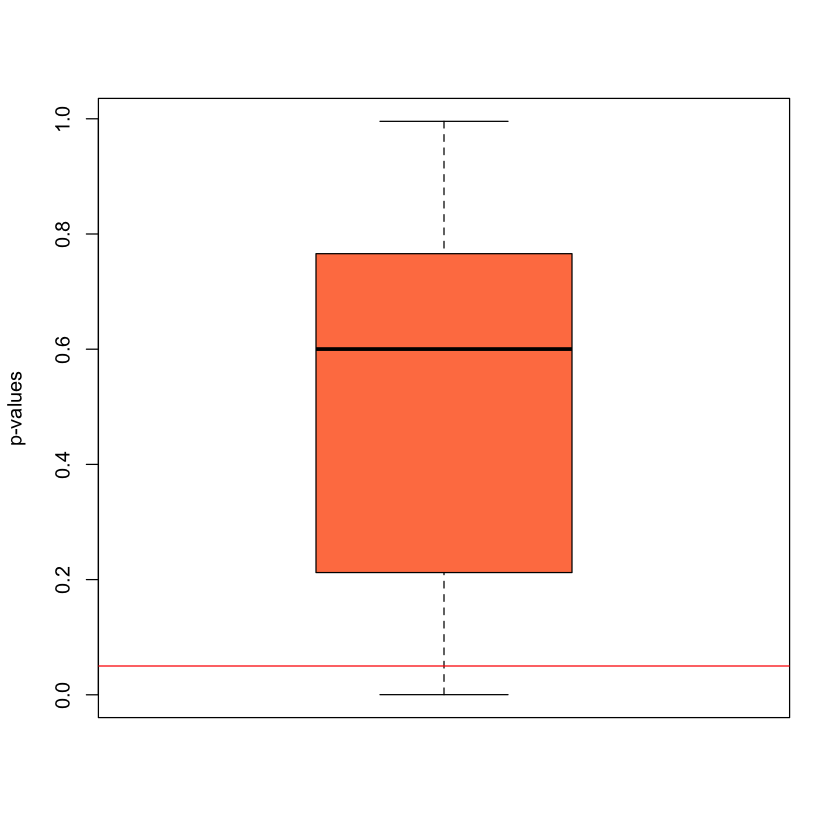

In [41]:
boxplot(pvalues_gausslgc, ylab='p-values', col="coral")
abline(h=0.05, col = "Red")

In [43]:
png(filename="pvalues_gausslgc.png", height=2000, width=2000, res=400)
boxplot(pvalues_gausslgc, ylab='p-values', col="coral")
abline(h=0.05, col = "Red")
dev.off()

pdf 
  2

----------------------------
Now, two variations of ```gaussian``` are used, where the two uniform numbers are not independent. The first one uses $u_1 \sim \mathrm{Unif}(0,1)$ and  $u_2 = \frac{u_1}{2}$, while the second one uses $u_1 \sim \mathrm{Unif}(0,1)$ and  $u_2 = \frac{u_1 + 1}{2}$

In [44]:
gaussian_not_ind = function(mu, sigma) {
    u = runif(1);
    u <- c(u, .5*u[1])
    z0 = sqrt(-2 * log(u[1])) * cos(2 * pi * u[2]);
    z1 = sqrt(-2 * log(u[1])) * sin(2 * pi * u[2]);
    datos = c(z0, z1);
    return (sigma * datos + mu);
}

In [45]:
gaussian_not_ind_2 = function(mu, sigma) {
    u = runif(1);
    u <- c(u, (u+1)/2)
    z0 = sqrt(-2 * log(u[1])) * cos(2 * pi * u[2]);
    z1 = sqrt(-2 * log(u[1])) * sin(2 * pi * u[2]);
    datos = c(z0, z1);
    return (sigma * datos + mu);
}

In [46]:
pvalues_notind1 <- numeric()
pvalues_notind2 <- numeric()

for (i in 1:100){    
    x <- numeric()
    y <- numeric()
    for (i in 1:2500){
      x <- c(x, gaussian_not_ind(0, 1))
      y <- c(y, gaussian_not_ind(0,1))
    }
    pvalues_notind1 <- c(pvalues_notind1, shapiro.test(x)$p)
    pvalues_notind2 <- c(pvalues_notind2, shapiro.test(y)$p)
}

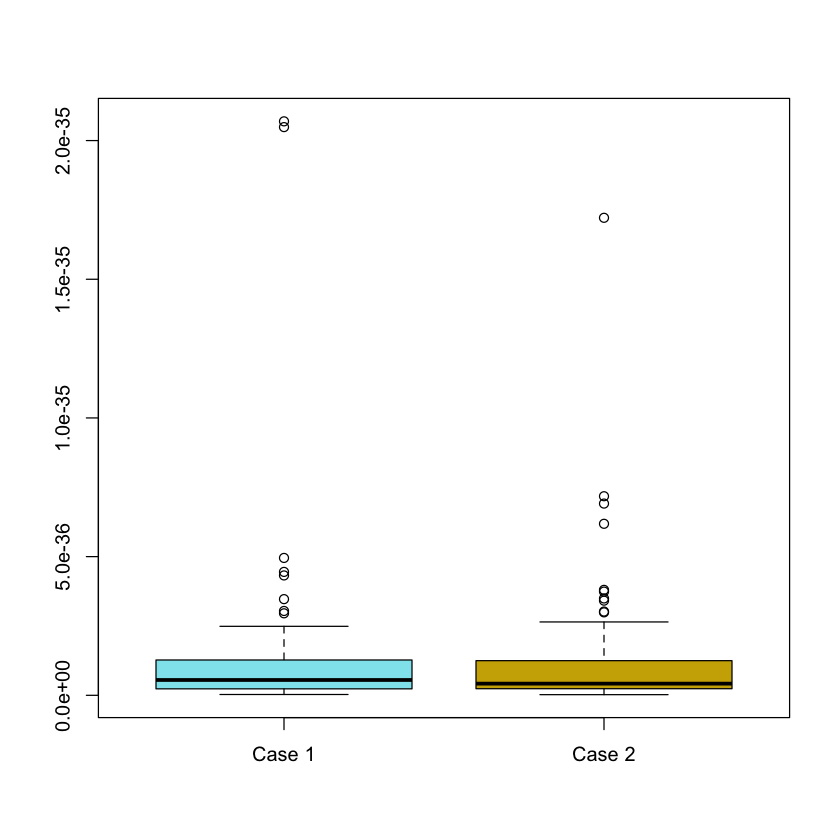

In [50]:
boxplot(pvalues_notind1, pvalues_notind2, 
        col = c("cadetblue2", "gold3"),
        names=c("Case 1", "Case 2"))
abline(h=0.05, col = "Blue")

In [51]:
png(filename="pvalues_notind.png", height=2000, width=2000, res=400)
boxplot(pvalues_notind1, pvalues_notind2, 
        col = c("cadetblue2", "gold3"),
        names=c("Case 1", "Case 2"))
abline(h=0.05, col = "Blue")
dev.off()

pdf 
  2

In [53]:
max(max(pvalues_notind1), max(pvalues_notind2))

[1] 2.069363e-35

In [54]:
table(pvalues_notind2 < 0.05)


TRUE 
 100 

In [55]:
table(pvalues_notind1 < 0.05)


TRUE 
 100 

***************************
#### Polar version of Box-Muller method
We use a variant of the Box-Muller method, ```gaussian_polar``` which does not make use of trigonometric function, and compare it to our original ```gaussian``` function

In [56]:
gaussian_polar <- function(mu, sigma){
    S <- 2
    while(S > 1){
        u <- runif(2)
        V1 <- 2*u[1] - 1
        V2 <- 2*u[2] - 1
        S <- (V1*V1) + (V2*V2)  
    }

    datos <- c(sqrt((-2*log(S))/S)*V1, sqrt((-2*log(S))/S)*V2)
    return (sigma * datos + mu)
    
}

In [78]:
pvalues_gausspolar <- numeric()
for(i in 1:100){
    x <- numeric()
    for (i in 1:2500){
        x <- c(x, gaussian_polar(0,1))
    }
    pvalues_gausspolar <- c(pvalues_gausspolar, shapiro.test(x)$p)
}

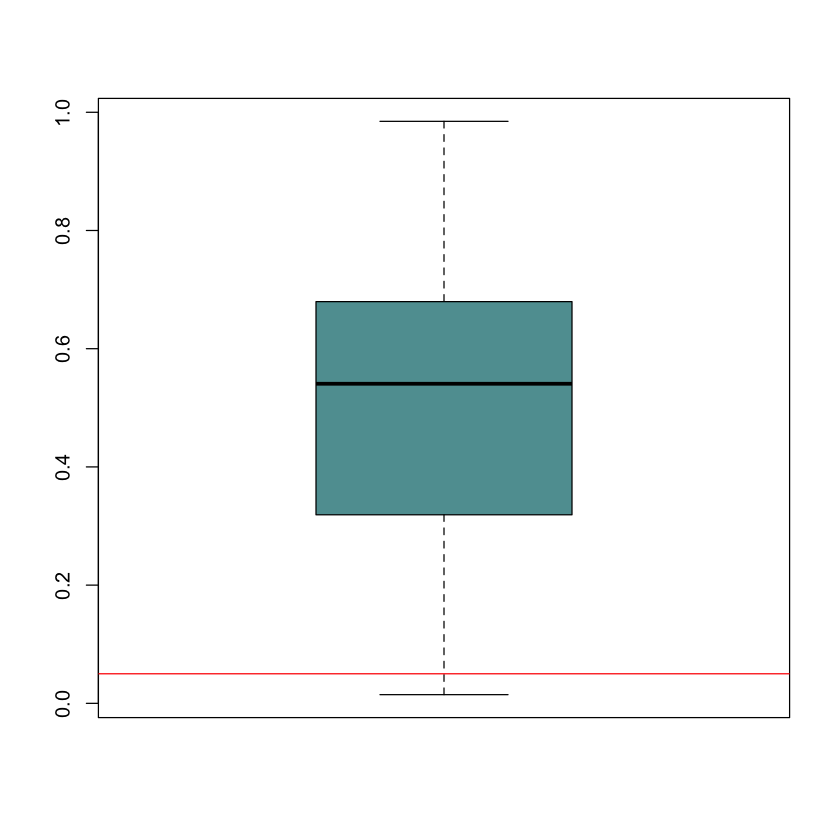

In [79]:
boxplot(pvalues_gausspolar, col="cadetblue")
abline(h=0.05, col = "Red")

In [80]:
png(filename="pvalues_gausspolar.png", height=2000, width=2000, res=400)
boxplot(pvalues_gausspolar, col="cadetblue")
abline(h=0.05, col = "Red")
dev.off()

pdf 
  2

In [81]:
table(pvalues_gausspolar < 0.05)


FALSE  TRUE 
   96     4 

In [111]:
time_gaussian <- numeric()
for (i in 1:1e3){
    rn <- proc.time()
    for(i in 1:1e3){
        x <- gaussian(0,1)
    }
    time <- proc.time()-rn
    time_gaussian <- c(time_gaussian, as.numeric(time)[3])
}

In [113]:
time_polar <- numeric()
for (i in 1:1e3){
    rn <- proc.time()
    for(i in 1:1e3){
        x <- gaussian_polar(0,1)
    }
    time <- proc.time()-rn
    time_polar <- c(time_polar, as.numeric(time)[3])
}

In [116]:
mean(time_gaussian)

[1] 0.004678

In [117]:
mean(time_polar)

[1] 0.005693

In [118]:
table(time_gaussian < time_polar)


FALSE  TRUE 
  228   772 

Function ```gaussian_polar```seems to be slower

***************************
#### Rejection method
The following algorithm uses exponentially distributed numbers with rate 1. 


In [68]:
rm_normal <- function(mu, sigma){
    Y <- rexp(2, 1)

    while(Y[2] - ((Y[1] - 1)**2)/2 < 0){
        Y <- rexp(2,1)
    }

    u <- runif(1)

    if(u <= .5){
        z <- Y[1]
    }
    else{
        z <- -Y[1]
    }

    return(sigma*z + mu)
}

In [69]:
pvalues_rm_normal <- numeric()
for (i in 1:100){
    x <- numeric()
    for (i in 1:5000){
        x <- c(x,rm_normal(5,2))
    }  
    pvalues_rm_normal <- c(pvalues_rm_normal, shapiro.test(x)$p)
}


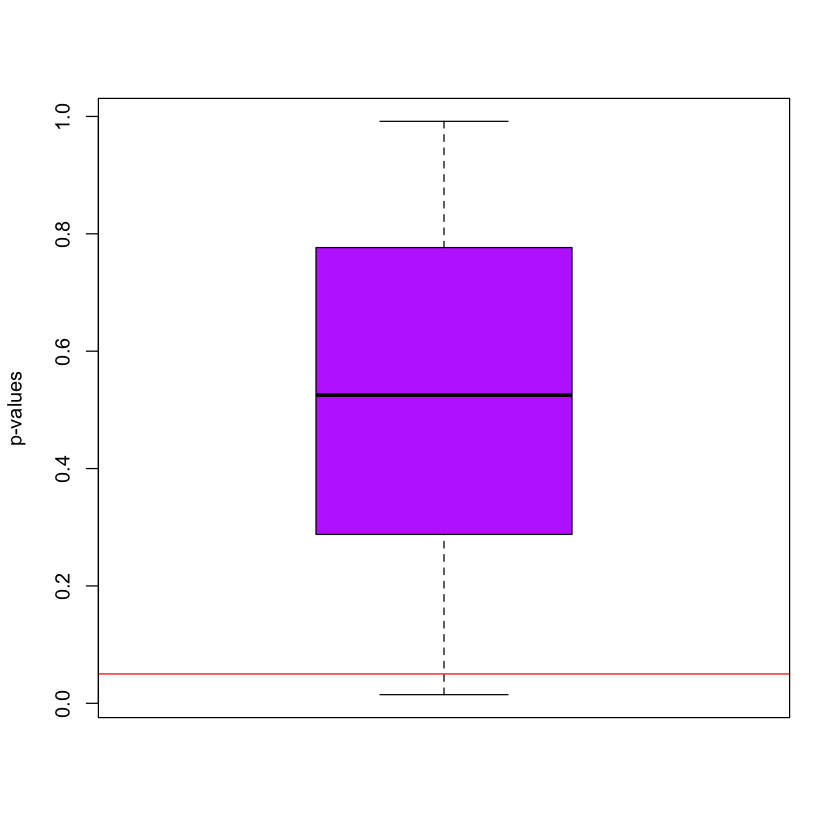

In [70]:
boxplot(pvalues_rm_normal, ylab='p-values', col="darkorchid1")
abline(h=0.05, col="Red")

In [71]:
png(filename="pvalues_rm_normal.png", height=2000, width=2000, res=400)
boxplot(pvalues_rm_normal, ylab='p-values', col="darkorchid1")
abline(h=0.05, col="Red")
dev.off()

pdf 
  2

In [169]:
table(pvalues_rm_normal < 0.05)


FALSE  TRUE 
   94     6 

In [121]:
x <- numeric()
for (i in 1:5000){
    x <- c(x, rm_normal(0,1))
}

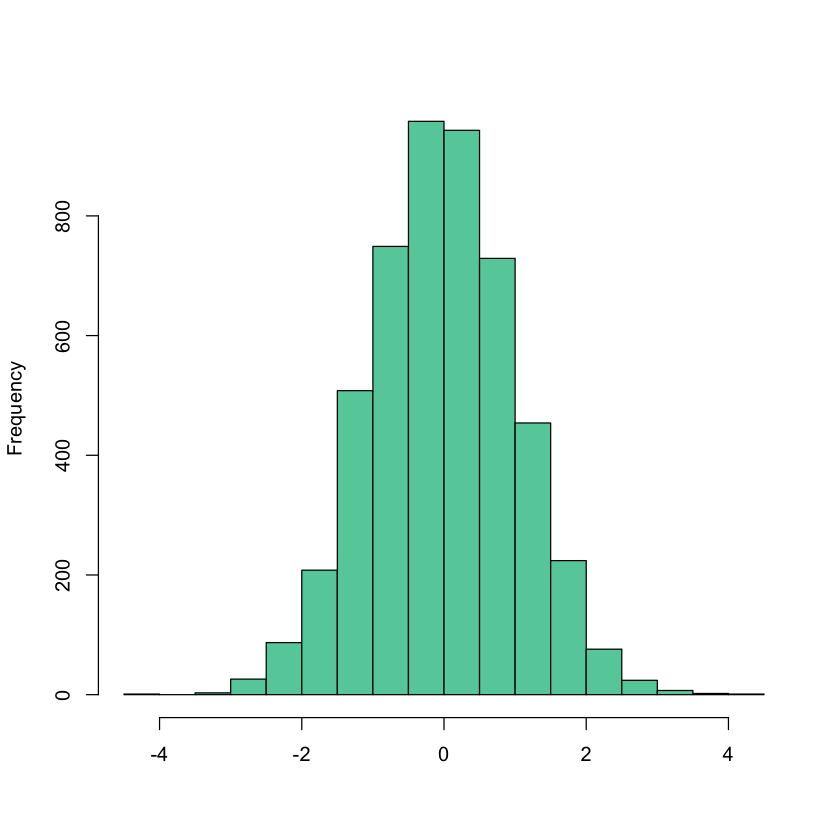

In [128]:
hist(x, main="", xlab="",col="aquamarine3")

In [129]:
png(filename="hist_rm_normal.png", height=2000, width=2000, res=400)
hist(x, main="", xlab="", col="aquamarine3")
dev.off()

pdf 
  2

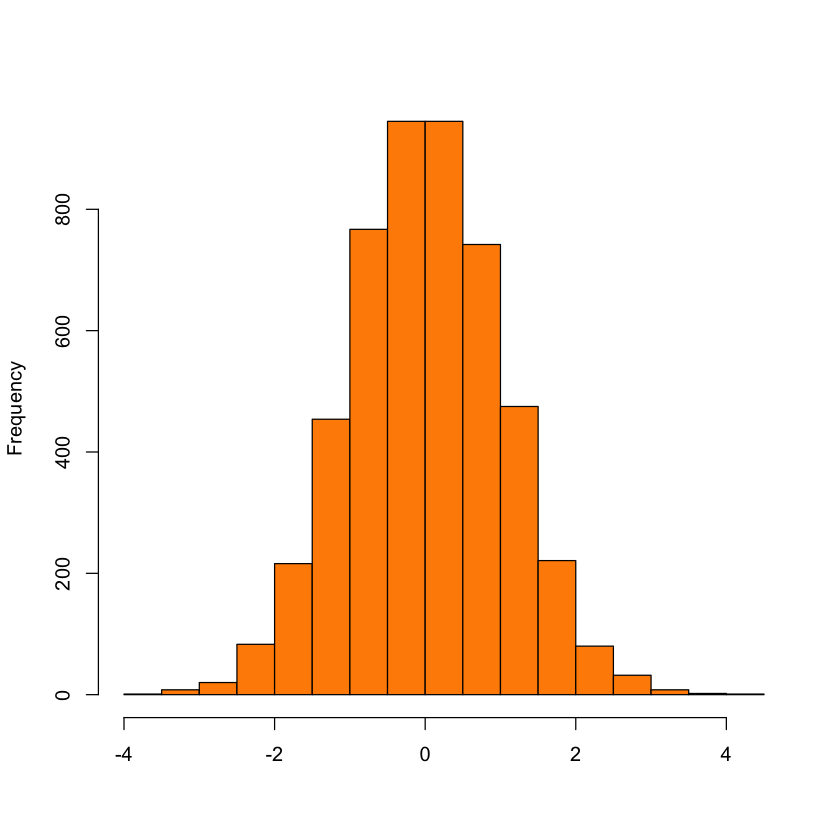

In [130]:
x <- rnorm(5000, mean = 0, 1)
hist(x, main="", xlab="", col="darkorange")

In [131]:
png(filename="hist_rnorm.png", height=2000, width=2000, res=400)
hist(x, main="", xlab="", col="darkorange")
dev.off()

pdf 
  2